<h1><center> ECS763P Natural Language Processing: Assignment 1</center></h1>
<h2><center> CRF sequence tagging for Movie Queries </center></h2>
<h3><center> Mughees Asif &#9644; 180288337 </center></h3>

---

## Abstract

This notebook involves reading in, pre-processing, training and developing a tagger on the training data from `trivia10k13train.bio.txt`, and finally testing the tagger on the data `trivia10k13test.bio.txt`, whilst attempting to get the best performing tagger across the different labels in the development process. The data was first split into a `80:20` ratio training and development set. Thereon, error analysis was executed on the development set to print out the **five** lowest classes for `precision` (false positives) and `recall` (false negatives). The `CRFSuite` from the `NLTK` package was then used to Part-Of-Speech (POS) tag the words in the dataset which increased the accuracy metrics by $21\%$, $33\%$ and $32\%$ for precision, recall and F1-score, respectively. Lastly, feature experimentation such as POS tagging more words with the windows of the previous and next words was also employed with $L2$ regularisation to reduce overfitting, which resulted in the final accuracy metrics of $86\%$, $79\%$ and $82\%$ for precision, recall and F1-score, respectively.

## Contents <a class="anchor" id="contents"></a>

&nbsp;&nbsp; Q1. **[Split the training data](#q1)** <br />
&nbsp;&nbsp; Q2. **[False Positives](#q2)** <br />
&nbsp;&nbsp; Q3. **[False Negatives](#q3)** <br />
&nbsp;&nbsp; Q4. **[POS Tags](#q4)** <br />
&nbsp;&nbsp; Q5. **[Feature experimentation](#q5)** <br />

<div class="alert alert-block alert-info">
<b>Tip:</b> To return to the contents, press the ☝ icon.</div>

<div class="alert alert-block alert-danger">
<b>Note:</b> The proceeding code blocks have been designed using techniques from the official QM labs, and where appropriate, the algorithms follow similar structure to generic algorithms found on GitHub/Stack Overflow. 
</div>

### Imports <a class="anchor" id="imports"></a> [☝](#contents)

In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata
from nltk.tag import CRFTagger
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display_html
from itertools import chain,cycle

### Preprocessing <a class="anchor" id="preprocess"></a> [☝](#contents)

In this section, the raw data is processed for simple classification with `out-of-the-box` feature extraction. 

Helper function to process the data from the `.txt` file.

In [2]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

Trivial preprocessing is applied that will be built upon in the next sections.

In [3]:
def preProcess(example):
    preprocessed_example = example 
    return preprocessed_example

training_data = [preProcess(example) for example in raw_training_data]

Official NLTK `CRFTagger` feature extraction which will have more features added in the upcoming sections.

In [4]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

Train the tagger.

In [5]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_pos.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


# 1. Split training data into 80% training, 20% development set (5 marks)<a class="anchor" id="q1"></a> [☝](#contents)

Splitting the data using **[array slicing](https://stackoverflow.com/questions/509211/understanding-slice-notation)**.

In [6]:
split = int(0.8 * len(training_data))
train_data = training_data[:split] 
test_data = training_data[split:] 

In [7]:
print("Total no. of samples:", len(training_data))
print('No. of training samples:', len(train_data))
print('No. of testing samples:', len(test_data))
assert len(training_data) == len(train_data) + len(test_data)

Total no. of samples: 7816
No. of training samples: 6252
No. of testing samples: 1564


# 2. Error analysis 1: False positives (5 marks) <a class="anchor" id="q2"></a> [☝](#contents)

Print out all the sentences related to the false positives. 

In [8]:
print("testing tagger...\n")

preds_fp = []
y_test_fp = []
for sent in test_data:

    sent_preds_fp = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true_fp = [s[1] for s in sent]

    for i in range(len(sent_preds_fp)):
        if sent_preds_fp[i] == sent_true_fp[i]:
            continue
        print('{1}:\n--------\nsentence: {0} \n'.format(sent, sent_preds_fp[i]))
        preds_fp.extend(sent_preds_fp)
        y_test_fp.extend(sent_true_fp)
        
print("done")

testing tagger...

I-Plot:
--------
sentence: [('omar', 'B-Actor'), ('sharif', 'I-Actor'), ('is', 'O'), ('a', 'B-Plot'), ('married', 'I-Plot'), ('man', 'I-Plot'), ('who', 'I-Plot'), ('falls', 'I-Plot'), ('in', 'I-Plot'), ('love', 'I-Plot'), ('with', 'I-Plot'), ('julie', 'B-Actor'), ('christie', 'I-Actor'), ('during', 'B-Plot'), ('the', 'I-Plot'), ('bolshevik', 'I-Plot'), ('revolution', 'I-Plot'), ('in', 'O'), ('this', 'O'), ('1965', 'B-Year'), ('oscar', 'B-Award'), ('winner', 'O')] 

I-Plot:
--------
sentence: [('omar', 'B-Actor'), ('sharif', 'I-Actor'), ('is', 'O'), ('a', 'B-Plot'), ('married', 'I-Plot'), ('man', 'I-Plot'), ('who', 'I-Plot'), ('falls', 'I-Plot'), ('in', 'I-Plot'), ('love', 'I-Plot'), ('with', 'I-Plot'), ('julie', 'B-Actor'), ('christie', 'I-Actor'), ('during', 'B-Plot'), ('the', 'I-Plot'), ('bolshevik', 'I-Plot'), ('revolution', 'I-Plot'), ('in', 'O'), ('this', 'O'), ('1965', 'B-Year'), ('oscar', 'B-Award'), ('winner', 'O')] 

I-Plot:
--------
sentence: [('omar', 'B-A


I-Plot:
--------
sentence: [('what', 'O'), ('s', 'O'), ('the', 'O'), ('recent', 'O'), ('movie', 'O'), ('in', 'O'), ('which', 'O'), ('amy', 'B-Actor'), ('adams', 'I-Actor'), ('is', 'O'), ('the', 'O'), ('estranged', 'B-Plot'), ('adult', 'I-Plot'), ('child', 'I-Plot'), ('of', 'I-Plot'), ('clint', 'B-Actor'), ('eastwood', 'I-Actor'), ('s', 'B-Plot'), ('character', 'I-Plot'), ('who', 'I-Plot'), ('is', 'I-Plot'), ('heavy', 'I-Plot'), ('into', 'I-Plot'), ('the', 'I-Plot'), ('baseball', 'I-Plot'), ('world', 'I-Plot'), ('and', 'I-Plot'), ('she', 'I-Plot'), ('meets', 'I-Plot'), ('a', 'I-Plot'), ('guy', 'I-Plot'), ('along', 'I-Plot'), ('the', 'I-Plot'), ('way', 'I-Plot')] 

I-Plot:
--------
sentence: [('what', 'O'), ('s', 'O'), ('the', 'O'), ('recent', 'O'), ('movie', 'O'), ('in', 'O'), ('which', 'O'), ('amy', 'B-Actor'), ('adams', 'I-Actor'), ('is', 'O'), ('the', 'O'), ('estranged', 'B-Plot'), ('adult', 'I-Plot'), ('child', 'I-Plot'), ('of', 'I-Plot'), ('clint', 'B-Actor'), ('eastwood', 'I-Acto


I-Plot:
--------
sentence: [('what', 'O'), ('1984', 'B-Year'), ('family', 'B-Genre'), ('movie', 'O'), ('featured', 'O'), ('ralph', 'B-Actor'), ('macchio', 'I-Actor'), ('as', 'O'), ('a', 'B-Plot'), ('bullied', 'I-Plot'), ('boy', 'I-Plot'), ('elisabeth', 'B-Actor'), ('shue', 'I-Actor'), ('as', 'B-Plot'), ('his', 'I-Plot'), ('girlfriend', 'I-Plot'), ('and', 'I-Plot'), ('pat', 'B-Actor'), ('morita', 'I-Actor'), ('as', 'B-Plot'), ('his', 'I-Plot'), ('mentor', 'I-Plot')] 

I-Plot:
--------
sentence: [('what', 'O'), ('1984', 'B-Year'), ('family', 'B-Genre'), ('movie', 'O'), ('featured', 'O'), ('ralph', 'B-Actor'), ('macchio', 'I-Actor'), ('as', 'O'), ('a', 'B-Plot'), ('bullied', 'I-Plot'), ('boy', 'I-Plot'), ('elisabeth', 'B-Actor'), ('shue', 'I-Actor'), ('as', 'B-Plot'), ('his', 'I-Plot'), ('girlfriend', 'I-Plot'), ('and', 'I-Plot'), ('pat', 'B-Actor'), ('morita', 'I-Actor'), ('as', 'B-Plot'), ('his', 'I-Plot'), ('mentor', 'I-Plot')] 

I-Plot:
--------
sentence: [('what', 'O'), ('1984', 'B-


O:
--------
sentence: [('what', 'O'), ('is', 'O'), ('the', 'O'), ('black', 'B-Genre'), ('and', 'I-Genre'), ('white', 'I-Genre'), ('critically', 'B-Opinion'), ('acclaimed', 'I-Opinion'), ('suspense', 'B-Genre'), ('horror', 'I-Genre'), ('film', 'O'), ('directed', 'O'), ('by', 'O'), ('hitchcock', 'B-Director'), ('released', 'O'), ('in', 'O'), ('1960', 'B-Year')] 

O:
--------
sentence: [('what', 'O'), ('is', 'O'), ('the', 'O'), ('black', 'B-Genre'), ('and', 'I-Genre'), ('white', 'I-Genre'), ('critically', 'B-Opinion'), ('acclaimed', 'I-Opinion'), ('suspense', 'B-Genre'), ('horror', 'I-Genre'), ('film', 'O'), ('directed', 'O'), ('by', 'O'), ('hitchcock', 'B-Director'), ('released', 'O'), ('in', 'O'), ('1960', 'B-Year')] 

O:
--------
sentence: [('what', 'O'), ('is', 'O'), ('the', 'O'), ('blockbuster', 'B-Opinion'), ('movie', 'O'), ('based', 'B-Origin'), ('on', 'I-Origin'), ('a', 'I-Origin'), ('book', 'I-Origin'), ('about', 'O'), ('a', 'O'), ('family', 'B-Plot'), ('of', 'I-Plot'), ('vampir

B-Plot:
--------
sentence: [('what', 'O'), ('is', 'O'), ('the', 'O'), ('jim', 'B-Actor'), ('carrey', 'I-Actor'), ('and', 'O'), ('ewan', 'B-Actor'), ('mcgregor', 'I-Actor'), ('movie', 'O'), ('about', 'O'), ('a', 'O'), ('man', 'B-Plot'), ('who', 'I-Plot'), ('after', 'I-Plot'), ('a', 'I-Plot'), ('car', 'I-Plot'), ('crash', 'I-Plot'), ('decides', 'I-Plot'), ('to', 'I-Plot'), ('live', 'I-Plot'), ('life', 'I-Plot'), ('to', 'I-Plot'), ('the', 'I-Plot'), ('fullest', 'I-Plot'), ('ends', 'I-Plot'), ('up', 'I-Plot'), ('in', 'I-Plot'), ('jail', 'I-Plot'), ('and', 'I-Plot'), ('meets', 'I-Plot'), ('his', 'I-Plot'), ('gay', 'I-Plot'), ('lover', 'I-Plot')] 

I-Plot:
--------
sentence: [('what', 'O'), ('is', 'O'), ('the', 'O'), ('jim', 'B-Actor'), ('carrey', 'I-Actor'), ('and', 'O'), ('ewan', 'B-Actor'), ('mcgregor', 'I-Actor'), ('movie', 'O'), ('about', 'O'), ('a', 'O'), ('man', 'B-Plot'), ('who', 'I-Plot'), ('after', 'I-Plot'), ('a', 'I-Plot'), ('car', 'I-Plot'), ('crash', 'I-Plot'), ('decides', 'I-P

Print the classification report and the five _lowest_ **false positive** classes.

In [9]:
report = classification_report(y_test_fp, preds_fp, output_dict=True)
print(classification_report(y_test_fp, preds_fp))
print(precision_recall_fscore_support(y_test_fp, preds_fp, average='macro'))  

print('\n\nPrecision:\n-----')
df = pd.DataFrame(report).transpose()
false_positives = df.sort_values(by='precision', ascending=True).head(5)['precision']
print(false_positives)

                  precision    recall  f1-score   support

         B-Actor       0.80      0.83      0.82      2648
         B-Award       0.62      0.45      0.52       212
B-Character_Name       0.79      0.10      0.18      1027
      B-Director       0.86      0.69      0.76      1211
         B-Genre       0.81      0.72      0.76      2050
       B-Opinion       0.43      0.21      0.28       747
        B-Origin       0.37      0.24      0.29       607
          B-Plot       0.22      0.20      0.21      3256
         B-Quote       0.46      0.09      0.15       141
  B-Relationship       0.79      0.38      0.52       530
    B-Soundtrack       0.44      0.07      0.12        99
          B-Year       0.96      0.99      0.98      1622
         I-Actor       0.80      0.83      0.82      3231
         I-Award       0.82      0.75      0.78       559
I-Character_Name       0.80      0.09      0.16       858
      I-Director       0.85      0.66      0.74      1201
         I-Ge

# 3. Error analysis 2: False negatives (5 marks) <a class="anchor" id="q3"></a> [☝](#contents)

Print the five _lowest_ **false negative** classes and all the associated sentences.

In [10]:
print('Recall:\n-----')
false_negatives = df.sort_values(by='recall', ascending=True).head(5)['recall']
print(false_negatives)
print()

categories = false_negatives.index.tolist() 

preds_fn = []
y_test_fn = []

for sent in test_data:
    sent_preds_fn = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true_fn = [s[1] for s in sent]

    for i in range(len(sent_preds_fn)):
        if  sent_preds_fn[i] not in categories:
            continue
        if sent_preds_fn[i] == sent_true_fn[i]:
            continue
        print('{1}:\n--------\nsentence: {0} \n'.format(sent, sent_preds_fn[i]))
        print()
    preds_fn.extend(sent_preds_fn)
    y_test_fn.extend(sent_true_fn)
print("done")

Recall:
-----
I-Soundtrack        0.069705
B-Soundtrack        0.070707
I-Character_Name    0.090909
B-Quote             0.092199
I-Opinion           0.092843
Name: recall, dtype: float64

I-Opinion:
--------
sentence: [('play', 'B-Quote'), ('it', 'I-Quote'), ('again', 'I-Quote'), ('sam', 'I-Quote'), ('is', 'O'), ('one', 'O'), ('of', 'O'), ('the', 'O'), ('memorable', 'O'), ('quotes', 'O'), ('from', 'O'), ('this', 'O'), ('classic', 'B-Opinion'), ('humphrey', 'B-Actor'), ('bogart', 'I-Actor'), ('romance', 'B-Genre')] 


I-Opinion:
--------
sentence: [('play', 'B-Quote'), ('it', 'I-Quote'), ('again', 'I-Quote'), ('sam', 'I-Quote'), ('is', 'O'), ('one', 'O'), ('of', 'O'), ('the', 'O'), ('memorable', 'O'), ('quotes', 'O'), ('from', 'O'), ('this', 'O'), ('classic', 'B-Opinion'), ('humphrey', 'B-Actor'), ('bogart', 'I-Actor'), ('romance', 'B-Genre')] 


I-Opinion:
--------
sentence: [('play', 'B-Quote'), ('it', 'I-Quote'), ('again', 'I-Quote'), ('sam', 'I-Quote'), ('is', 'O'), ('one', 'O'), (

done


# 4. Incorporating POS tags as features (15 marks) <a class="anchor" id="q4"></a> [☝](#contents)

The CRF part-of-speech (POS) tagger is used to add POS tags to the words in the training data. The CRF tagger only takes strings as input so the word and POS tag need to be merged together (with a special symbol, e.g. $@$).

In [19]:
def preProcess_new(example):
    tmp_words = []
    for word, label in example:
        tmp_words.append(word)

    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    pos_list = posttagger.tag(tmp_words)
    
    # Concatenate @ to the words
    symbol_concat = []
    for word, label in pos_list:
        symbol_concat.append(word + "@" + label)
    
    # Concatenate the merged POS tag words
    final_concat = []
    for word, label in example:
        final_concat.append(label)

    possed = list(zip(symbol_concat, final_concat))
    
    preprocessed_example = possed  
    return preprocessed_example

Making a new split to run comparison of the accuracy metrics against not using POS tags.

In [20]:
training_data_new = [preProcess_new(example) for example in raw_training_data]

split_new = int(0.8 * len(training_data_new))
train_data_new = training_data_new[:split_new] 
test_data_new = training_data_new[split_new:] 

Extend the `get_features` function from [Preprocessing](#preprocess) to incorporate the POS tags in the feature extraction.

In [21]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

def get_features_new(tokens, idx):
    token = tokens[idx]
    split_token = token.split("@")
    if len(split_token) == 1:
        print(split_token)

    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if split_token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, split_token[0]) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix to length 3
    for i in range(1, 4):
        if len(split_token[0]) > i:
            feature_list.append("SUFFIX_" + split_token[0][-i:])
        
    feature_list.append("WORD_" + split_token[0])
    feature_list.append("POSTAG_" + split_token[1])

    return feature_list

Train the new tagger with the POS tags.

In [22]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct_new = CRFTagger(feature_func=get_features_new)  # initialize tagger with get_features function

print("training tagger...")
ct_new.train(train_data_new, TAGGER_PATH)
print("done")

training tagger...
done


Testing the new tagger.

In [23]:
print("testing tagger...")

preds_new = []
y_test_new = []
for sent in test_data_new:
    sent_preds_new = [x[1] for x in ct_new.tag([s[0] for s in sent])]
    sent_true_new = [s[1] for s in sent]
    
    for i in range(len(sent_preds_new)):
        if sent_preds_new[i] == sent_true_new[i]:
            continue
    preds_new.extend(sent_preds_new)
    y_test_new.extend(sent_true_new)
    
print("done")

testing tagger...
done


Print the classification report and the five lowest false positive and false negative classes.

In [24]:
# Output the classification report (which you should save each time for comparing your models)
report_new = classification_report(y_test_new, preds_new, output_dict=True)
print(classification_report(y_test_new, preds_new))
print(precision_recall_fscore_support(y_test_new, preds_new, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.91      0.94      0.92      1231
         B-Award       0.80      0.68      0.73        75
B-Character_Name       0.86      0.24      0.37       212
      B-Director       0.92      0.83      0.87       472
         B-Genre       0.90      0.85      0.87       805
       B-Opinion       0.57      0.31      0.40       160
        B-Origin       0.61      0.47      0.53       159
          B-Plot       0.56      0.51      0.53      1221
         B-Quote       0.80      0.33      0.47        24
  B-Relationship       0.87      0.55      0.68       125
    B-Soundtrack       0.50      0.08      0.13        13
          B-Year       0.98      1.00      0.99       703
         I-Actor       0.92      0.95      0.93      1731
         I-Award       0.85      0.86      0.86       202
I-Character_Name       0.89      0.25      0.39       165
      I-Director       0.92      0.83      0.87       456
         I-Ge

In [25]:
df_new = pd.DataFrame(report_new).transpose()
print('Precision:\n-----')
false_positives_new = df_new.sort_values(by='precision', ascending=True).head(5)['precision']
print(false_positives_new)
print('\nRecall:\n-----')
false_negatives_new = df_new.sort_values(by='recall', ascending=True).head(5)['recall']
print(false_negatives_new)

Precision:
-----
I-Opinion       0.152174
B-Soundtrack    0.500000
B-Plot          0.558036
B-Opinion       0.569767
B-Origin        0.611570
Name: precision, dtype: float64

Recall:
-----
B-Soundtrack        0.076923
I-Soundtrack        0.146341
I-Opinion           0.166667
B-Character_Name    0.235849
I-Character_Name    0.248485
Name: recall, dtype: float64


### Comparison of using and not using POS tags

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>display_side_by_side</code> function is taken from <b><a href='https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side'>this</a></b> Stack Overflow post to aid comparison.
</div>

In [26]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [27]:
display_side_by_side(df, df_new, titles=['Without POS Tags','With POS Tags'])

,precision,recall,f1-score,support
B-Actor,0.804180,0.828172,0.816000,2648.000000
B-Award,0.615385,0.452830,0.521739,212.000000
B-Character_Name,0.785185,0.103213,0.182444,1027.000000
B-Director,0.857438,0.685384,0.761817,1211.000000
B-Genre,0.813671,0.720000,0.763975,2050.000000
B-Opinion,0.432584,0.206158,0.279238,747.000000
B-Origin,0.365239,0.238880,0.288845,607.000000
B-Plot,0.215287,0.198096,0.206334,3256.000000
B-Quote,0.464286,0.092199,0.153846,141.000000
B-Relationship,0.790698,0.384906,0.517766,530.000000


The comparison above shows a marked improvement in all macro average metrics with a net increase of $21\%$, $33\%$ and $32\%$ across precision, recall and the F1-score, respectively. 

# 5. Feature experimentation and other optimization for optimal macro average (30 marks) <a class="anchor" id="q5"></a> [☝](#contents)

This section includes the optimisation of the feature extraction process, where additional features have been added to increase the `macro average f-score` (i.e. average f-score across all classes) on the 20% development data.

In [28]:
pos_tags_new = [
    "PREF_", 
    "PREV_WORD_", 
    "PREV_POSTAG_", 
    "SEC_PREV_WORD_", 
    "SEC_PREV_POSTAG_", 
    "THIRD_PREV_WORD_",
    "THIRD_PREV_POSTAG_"
]

The aforementioned features are added to the `get_features_final` function to test the effect of added features on the `trivia10k13test.bio.txt` dataset.

In [29]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

def get_features_final(tokens, idx):
    
    token = tokens[idx]
    split_token = token.split("@")
    if len(split_token) == 1:
        print(split_token)
        
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if split_token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, split_token[0]) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")
    
    # Suffix and prefix
    for i in range(1, 4):
        if len(split_token[0]) > i:
            feature_list.append("SUF_" + split_token[0][-i:])
        if len(split_token[0]) > i:
            feature_list.append(pos_tags_new[0] + split_token[0][:i])
    
    # New features 
    for i in range(0, 2):
        if i == 0:
            if idx > i:
                split_prev_token = tokens[idx - 1].split("@")
                feature_list.append(pos_tags_new[1] + split_prev_token[0])
                feature_list.append(pos_tags_new[2] + split_prev_token[1])        
        if i == 1:
            if idx > i:
                split_prev_token = tokens[idx - 2].split("@")
                feature_list.append(pos_tags_new[3] + split_prev_token[0])
                feature_list.append(pos_tags_new[4] + split_prev_token[1])
        if i == 2:
            if idx > i:
                split_prev_token = tokens[idx - 3].split("@")
                feature_list.append(pos_tags_new[5] + split_prev_token[0])
                feature_list.append(pos_tags_new[6] + split_prev_token[1])          
       
    feature_list.append("WORD_" + split_token[0])
    feature_list.append("POSTAG_" + split_token[1])

    return feature_list

 Preparing the data, training the `CRFTagger` by changing the minimum document frequency to 2, and adding the $L2$ regularisation hyperparameter to reduce overfitting. 

In [44]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess_new(example) for example in raw_test_data]


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_final.tagger"  # path to the tagger- it will save/access the model from here
ct_final = CRFTagger(feature_func=get_features_final)  # initialize tagger with get_features function

print("training tagger...")
ct_final.train(training_data_new, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features_final, training_opt={"feature.minfreq":4, "c2":0.1})  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

split = int(0.8 * len(training_data))
train_data_final = training_data[:split] 
test_data_final = training_data[split:] 

training tagger...
done


In [45]:
print("testing tagger...")

preds_final = []
y_test_final = []
for sent in test_data_new:
    sent_preds_final = [x[1] for x in ct_final.tag([s[0] for s in sent])]
    sent_true_final = [s[1] for s in sent]
    
    for i in range(len(sent_preds_final)):
        if sent_preds_final[i] == sent_true_final[i]:
            continue
    preds_final.extend(sent_preds_final)
    y_test_final.extend(sent_true_final)
    
print("done")

testing tagger...
done


In [46]:
# Output the classification report (which you should save each time for comparing your models)
report_final = classification_report(y_test_final, preds_final, output_dict=True)
print(classification_report(y_test_final, preds_final))
print(precision_recall_fscore_support(y_test_final, preds_final, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.97      0.97      0.97      1231
         B-Award       0.84      0.76      0.80        75
B-Character_Name       0.96      0.62      0.75       212
      B-Director       0.95      0.93      0.94       472
         B-Genre       0.92      0.89      0.90       805
       B-Opinion       0.70      0.51      0.59       160
        B-Origin       0.74      0.65      0.69       159
          B-Plot       0.68      0.63      0.65      1221
         B-Quote       0.90      0.75      0.82        24
  B-Relationship       0.86      0.62      0.72       125
    B-Soundtrack       0.80      0.62      0.70        13
          B-Year       0.99      1.00      0.99       703
         I-Actor       0.97      0.98      0.98      1731
         I-Award       0.92      0.88      0.90       202
I-Character_Name       0.97      0.68      0.80       165
      I-Director       0.96      0.94      0.95       456
         I-Ge

In [47]:
df_final = pd.DataFrame(report_final).transpose()
print('Precision:\n-----')
print(df_final.sort_values(by='precision', ascending=True).head(5)['precision'])
print('\nRecall:\n-----')
print(df_final.sort_values(by='recall', ascending=True).head(5)['recall'])

Precision:
-----
I-Opinion         0.581081
B-Plot            0.677591
B-Opinion         0.698276
B-Origin          0.735714
I-Relationship    0.768519
Name: precision, dtype: float64

Recall:
-----
B-Opinion           0.506250
I-Opinion           0.511905
B-Soundtrack        0.615385
B-Relationship      0.616000
B-Character_Name    0.617925
Name: recall, dtype: float64


In [50]:
display_side_by_side(df_new, df_final, titles=['Normal features','Added features'])

,precision,recall,f1-score,support
B-Actor,0.912768,0.935012,0.923756,1231.000000
B-Award,0.796875,0.680000,0.733813,75.000000
B-Character_Name,0.862069,0.235849,0.370370,212.000000
B-Director,0.918033,0.830508,0.872080,472.000000
B-Genre,0.896867,0.853416,0.874602,805.000000
B-Opinion,0.569767,0.306250,0.398374,160.000000
B-Origin,0.611570,0.465409,0.528571,159.000000
B-Plot,0.558036,0.511876,0.533960,1221.000000
B-Quote,0.800000,0.333333,0.470588,24.000000
B-Relationship,0.873418,0.552000,0.676471,125.000000


The comparison above shows a marked improvement in all macro average accuracy metrics when new features are added with a net increase of $12\%$, $30\%$ and $26\%$ across precision, recall and the F1-score, respectively. 

<div class="alert alert-block alert-warning">
    <b>Warning:</b> The <code>confusion_matrix_heatmap</code> function is taken from the official QM labs.
</div>

Helper function to print out the confusion matrix heatmap to visualise the accuracy metrics.

In [48]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

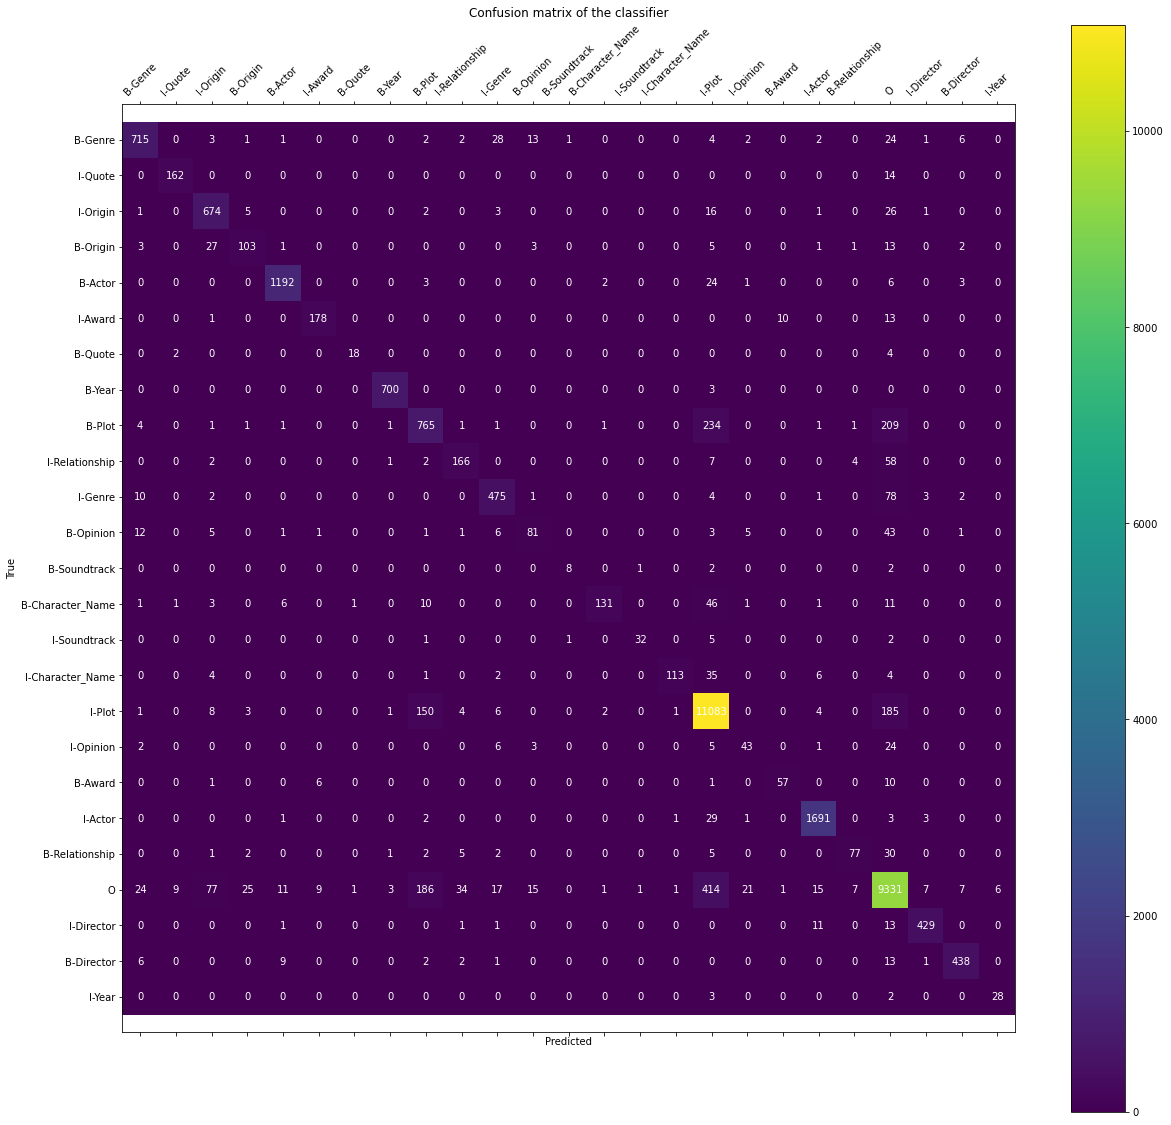

In [49]:
confusion_matrix_heatmap(y_test_final, preds_final)